# imports

In [10]:
from alibi_detect.cd import KSDrift

import numpy as np 
import pandas as pd 
from sklearn.datasets import make_classification 
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import classification_report 

import matplotlib.pyplot as plt 
import seaborn as sns 

# make synthetic data

In [2]:
# Create a synthetic dataset
X, y = make_classification(n_samples=10000, n_features=20, n_classes=2, weights=[0.99, 0.01], random_state=42)
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42) 


# Create drifts in the test set
drift = 0.5
X_test_drifted = X_test.copy()

# Introduce multiple drifts in the test set
X_test_drifted[:, 0] = X_test_drifted[:, 0] + drift
X_test_drifted[:, 1] = X_test_drifted[:, 1] * 2
X_test_drifted[y_test == 1, 2] = X_test_drifted[y_test == 1, 2] - drift 


# check drifts

In [20]:
# Use Alibi-Detect's KSDrift to analyze drift between X_test and X_test_drifted
p_value_threshold = 0.05
cd = KSDrift(p_val=p_value_threshold, x_ref=X_test)
drift_detection = cd.predict(X_test_drifted)

# Extract drift detection results
distances = drift_detection['data']['distance']
p_values = drift_detection['data']['p_val']

# Identify drifted variables
drifted_variables = np.where(p_values < p_value_threshold)[0]

print("Drifted variables:", drifted_variables)
print("Distances for drifted variables:", distances[drifted_variables])

Drifted variables: [0 1]
Distances for drifted variables: [0.272      0.46833333]


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.5 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with si

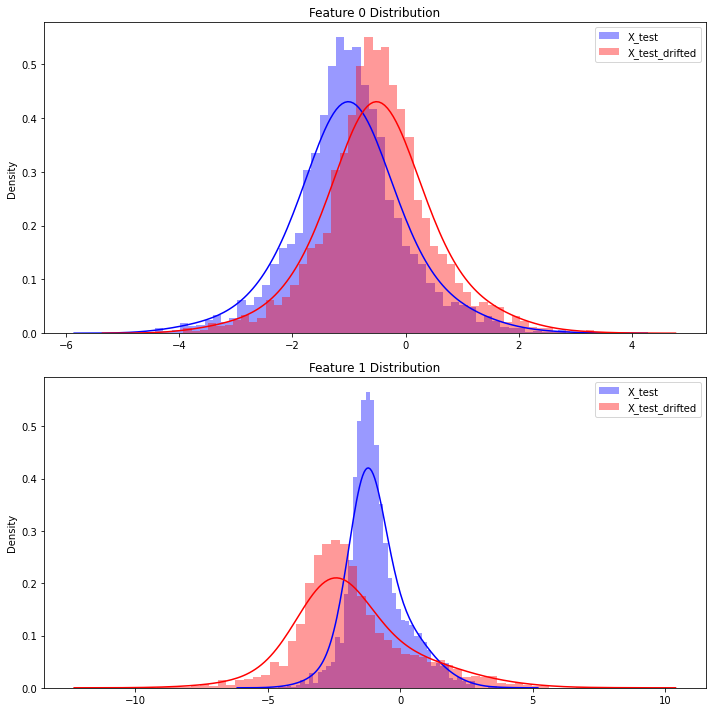

In [21]:
n_features = len(drifted_variables)

# Set up the figure
fig, axes = plt.subplots(nrows=n_features, ncols=1, figsize=(10, 5 * n_features))

# Iterate through each feature
for i in range(n_features):
    # Plot the distribution of the feature in the original dataset
    sns.distplot(X_test[:, i], ax=axes[i], color='blue', kde_kws={'bw': 0.5}, label='X_test')
    
    # Plot the distribution of the feature in the drifted dataset
    sns.distplot(X_test_drifted[:, i], ax=axes[i], color='red', kde_kws={'bw': 0.5}, label='X_test_drifted')
    
    axes[i].set_title(f'Feature {i} Distribution')
    axes[i].legend()

plt.tight_layout()
plt.show()

# model

In [22]:
# Train a logistic regression model
clf = LogisticRegression(random_state=42)
clf.fit(X_train, y_train) 

# Predict using the model
y_pred = clf.predict(X_test_drifted)

# results raw model on drifted data

In [70]:
# Check the classification report before post-processing
print("Classification Report before Post-processing:")
print(classification_report(y_test, y_pred))


Classification Report before Post-processing:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      2964
           1       0.21      0.08      0.12        36

    accuracy                           0.99      3000
   macro avg       0.60      0.54      0.56      3000
weighted avg       0.98      0.99      0.98      3000



# results reframed model on drifted data

Domain-specific heuristic: We create a heuristic function that takes into account patterns identified in the drifted data. In this case, we consider instances with the first feature greater than feature_threshold1 and the second feature less than feature_threshold2 as fraud. We also classify instances with the third feature less than feature_threshold2 as non-fraud.

In [78]:
# Analyze historical misclassified fraud instances
misclassified_fraud = X_test_drifted[(y_test == 1) & (y_pred == 0)]
mean_misclassified_fraud = misclassified_fraud.mean(axis=0)

# Analyze the historical misclassified fraud instances
mean_misclassified_fraud = misclassified_fraud.mean(axis=0)

# Define the threshold based on the analysis of historical misclassified instances
distance_threshold = 4

# Domain-specific heuristic: Correct predictions based on patterns identified in historical misclassified instances
def deterministic_heuristic(row):
    distance_to_misclassified_mean = np.linalg.norm(row[:-1] - mean_misclassified_fraud)
    if distance_to_misclassified_mean < distance_threshold:
        return 1
    return row[-1]

y_pred_deterministic_heuristic = y_pred.copy()
y_pred_deterministic_heuristic = np.apply_along_axis(deterministic_heuristic, 1, np.column_stack((X_test_drifted, y_pred_deterministic_heuristic)))

print("Classification Report for Deterministic Domain-specific Heuristic:")
print(classification_report(y_test, y_pred_deterministic_heuristic))


Classification Report for Deterministic Domain-specific Heuristic:
              precision    recall  f1-score   support

           0       0.99      0.92      0.96      2964
           1       0.05      0.36      0.10        36

    accuracy                           0.92      3000
   macro avg       0.52      0.64      0.53      3000
weighted avg       0.98      0.92      0.95      3000

